The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Hello Sim:  c3e55ca6-e5a7-440e-a5f0-0aae85a126e4
--------------------------------------------------
lens_1 height [7.0e-05 7.5e-05 8.0e-05]
lens_1 exponent [0.0]
lens_2 height [7.5e-05 8.0e-05]
lens_2 exponent [2.  2.1]
Generating 12 Simulations
[{'exponent': 0.0, 'height': 7e-05, 'medium': 'medium_1', 'name': 'lens_1'},
 {'exponent': 2.0, 'height': 7.5e-05, 'medium': 'medium_1', 'name': 'lens_2'}]
--------------------
[{'exponent': 0.0, 'height': 7e-05, 'medium': 'medium_1', 'name': 'lens_1'},
 {'exponent': 2.1, 'height': 7.5e-05, 'medium': 'medium_1', 'name': 'lens_2'}]
--------------------
[{'exponent': 0.0, 'height': 7e-05, 'medium': 'medium_1', 'name': 'lens_1'},
 {'exponent': 2.0, 'height': 8e-05, 'medium': 'medium_1', 'name': 'lens_2'}]
--------------------
[{'exponent': 0.0, 'height': 7e-05, 'medium': 'medium_1', 'name': 'lens_1'},
 {'exponent': 2.1, 'height': 8e-05, 'medium': 'medium_1', 'n

Generating simulation: 100%|██████████| 4/4 [00:00<00:00, 668.55it/s]


--------------------------------------------------
Starting Simulation live-beetle (216c13f044) with 4 stages.


Saving simulation: 100%|██████████| 4/4 [00:14<00:00,  3.72s/it]    


--------------------------------------------------
--------------------------------------------------


Generating simulation: 100%|██████████| 4/4 [00:00<00:00, 668.76it/s]


--------------------------------------------------
Starting Simulation handy-dassie (d4b092eee1) with 4 stages.


Saving simulation: 100%|██████████| 4/4 [00:16<00:00,  4.22s/it]    


--------------------------------------------------
--------------------------------------------------


Generating simulation: 100%|██████████| 4/4 [00:00<00:00, 1002.46it/s]


--------------------------------------------------
Starting Simulation select-dragon (f5893932a7) with 4 stages.


Saving simulation: 100%|██████████| 4/4 [00:17<00:00,  4.42s/it]    


--------------------------------------------------
--------------------------------------------------


Generating simulation: 100%|██████████| 4/4 [00:00<00:00, 857.16it/s]


--------------------------------------------------
Starting Simulation noted-glider (1d7d19cc24) with 4 stages.


Saving simulation: 100%|██████████| 4/4 [00:18<00:00,  4.60s/it]    


--------------------------------------------------
--------------------------------------------------


Generating simulation: 100%|██████████| 4/4 [00:00<00:00, 580.47it/s]


--------------------------------------------------
Starting Simulation noted-baboon (31b0e7b980) with 4 stages.


Saving simulation: 100%|██████████| 4/4 [00:16<00:00,  4.05s/it]    


--------------------------------------------------
--------------------------------------------------


Generating simulation: 100%|██████████| 4/4 [00:00<00:00, 979.69it/s]


--------------------------------------------------
Starting Simulation nice-kid (3c0053a1fd) with 4 stages.


Saving simulation:   0%|          | 0/4 [00:00<?, ?it/s]    \\ad.monash.edu\home\user028\pcle0002\documents\repos\lens_simulation\src\lens_simulation\utils.py:46: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()
Saving simulation: 100%|██████████| 4/4 [00:17<00:00,  4.47s/it]    


--------------------------------------------------
--------------------------------------------------


Generating simulation: 100%|██████████| 4/4 [00:00<00:00, 1002.64it/s]


--------------------------------------------------
Starting Simulation boss-cod (f3d3f49c33) with 4 stages.


Saving simulation:  50%|█████     | 2/4 [00:09<00:09,  4.72s/it]    


KeyboardInterrupt: 

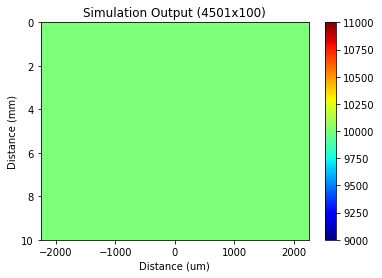

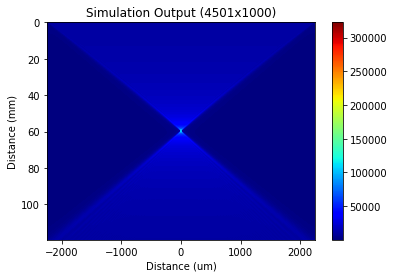

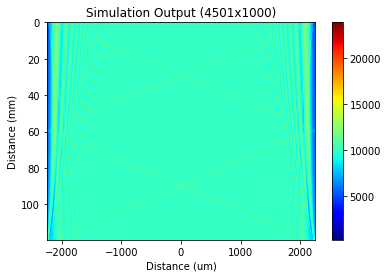

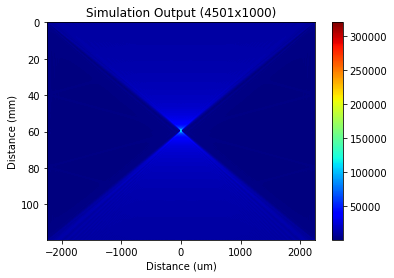

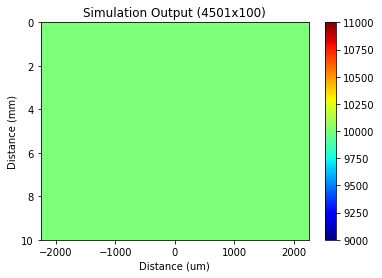

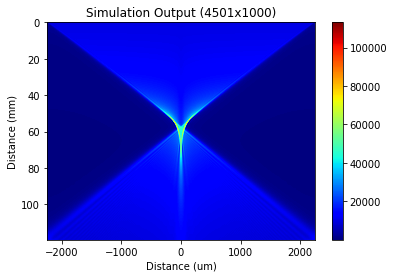

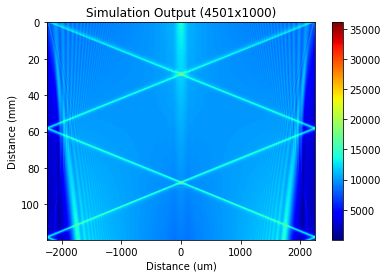

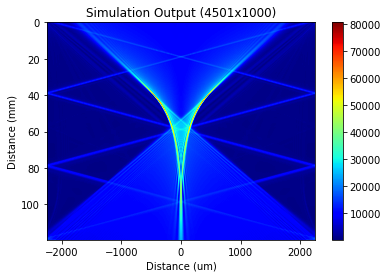

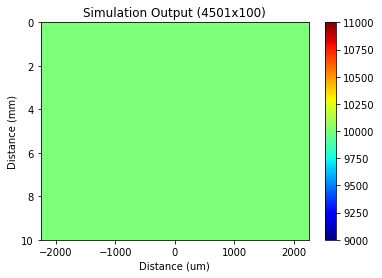

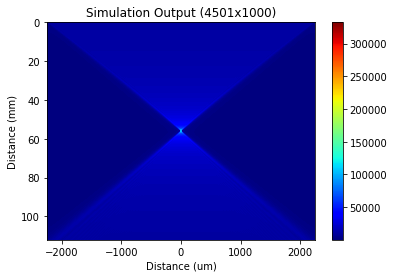

In [103]:
%load_ext autoreload 
%autoreload 2
from lens_simulation import SimulationRunner, Lens


sim_runner = SimulationRunner.SimulationRunner("config.yaml")
sim_runner.initialise_simulation()
sim_runner.setup_simulation()
sim_runner.run_simulations()

# Test github

## Simulation Class
Test example simulation



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
--------------------------------------------------
Running Simulation expert-llama (767bf84b6b)
Setting up simulation stage 0
Setting up simulation stage 1
Setting up simulation stage 2
Setting up simulation stage 3
Starting Simulation with 4 stages.
Simulating: {'lens':  Lens (diameter: 0.0045, height: 7e-05, medium: 0.0), 'output': Medium(), 'n_slices': 100, 'start_distance': 0, 'finish_distance': 0.01, 'options': {'save': 'True,', 'use_equivalent_focal_distance': False, 'focal_distance_multiple': 2.0}}
--------------------
Propagating Wavefront with Parameters
Lens:  Lens (diameter: 0.0045, height: 7e-05, medium: 0.0)
Medium: Medium()
Slices: 100, Start: 0.00e+00m, Finish: 1.00e-02m
Passed Wavefront: False
--------------------
Simulating: {'lens':  Lens (diameter: 0.0045, height: 7e-05, medium: 2.0), 'output': Medium(), 'n_slices': 1000, 'start_distance': 0.0, 'finish_distance': 0.128050876010781

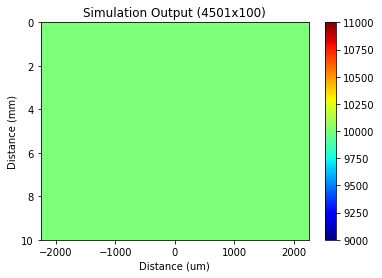

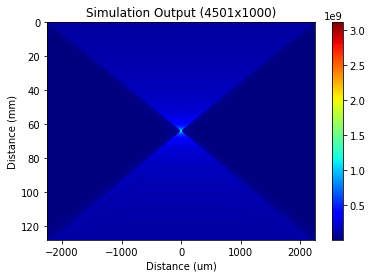

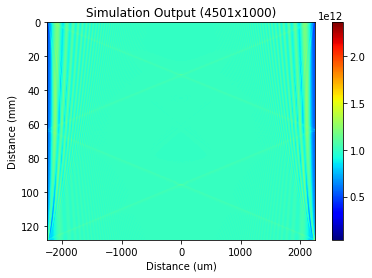

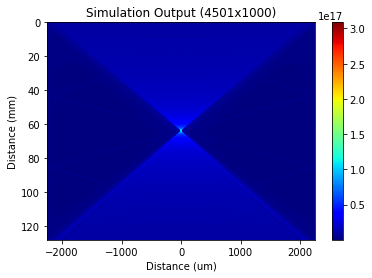

In [135]:
# %load_ext autoreload
# %autoreload 2
# from lens_simulation import Simulation
# import uuid
# import os
# import yaml

# with open("config.yaml", "r") as f:
#     conf = yaml.full_load(f)

# run_id = uuid.uuid4()  # run_id is for when running a batch of sims, each sim has unique id
# data_path = os.path.join(os.getcwd() , "log",  str(run_id))
# config = {"run_id": run_id, "parameters": None, "log_dir": data_path, 
#             "sim_parameters": conf["sim_parameters"], "options": conf["options"],
#             "mediums": conf["mediums"], "lenses": conf["lenses"],
#             "stages": conf["stages"]}

# sim = Simulation.Simulation(config)
# sim.run_simulation()